In [1]:
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, datetime, pylab
import pylab as P
from scipy.signal import butter, lfilter, filtfilt
#import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import adfuller

from mstats import *
import utilities_modules as um

print(mpl.__version__)

3.8.0


In [2]:
fpath_cases = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_bwfilter_3d_10percentile_noshift.dat'
fpath_cases_vrile = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_meanremoved_3d_10percentile_noshift.dat'
fpath_cases_vrilesum = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_allvriles_3d_10percentile_noshift.dat'

fpath_climo = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/NH_seaice_dextent_int_longtermmean_errorbars_1981_2010.dat'
fpath_raw = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/N_seaice_extent_daily_v3.0.csv'
fpath_minseptextent = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/NH_09_seaice_area_daily.dat'
fpath_3dsums = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_bwfilter_3d_100percentile_noshift.dat'

imagedir = '/Users/scavallo/Documents/scripts/python_scripts/images/'

write_top_bottom_events = 'False'
outfile_path1 = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/most_cumulativeloss_25percentile.dat'
outfile_path2 = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/least_cumulativeloss_75percentile.dat'


plot_option = 1 # 1 for histogram, 2 for probability density function
plot_season_option = 'jja' # options are: 'ann', 'djf', 'mam', 'jja', 'son', or 'non_jja'
remove_double_count = 'False'
plot_percent_from_events = 'True'
#periods2compare_cutoffs = [1989,1999,2009]
#periods2compare_cutoffs = [1990,2000,2010]
#periods2compare_cutoffs = [1993,2003,2013]
periods2compare_cutoffs = [1991,2002,2013]
ndays_same_event = 0 #3 # must match number of days from fpath_cases file sum
npasses_smooth = 0
label_fontsize = 18
legend_fontsize = 12
bw_filt_climo = 'False'
#figdescript = '10percentile_bwfilter_3d_dtUnique01'
figdescript = '5percentile_bwfilter_3d_' + plot_season_option 

years_analysis = [1989,2023]

labeltext_climo = r'$\Delta$SIE_climate (1989-2018)'
labeltext_record = r'$\Delta$SIE_record (1989-2023)'
labeltext_meanplusbw = r'$\Delta$SIE$_{total}$'
labeltext_bw = r'$\Delta$SIE$_{bwfilt}$'

In [3]:
#   NSIDC sea ice extent:
#       ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data
#   NSIDC gridded concentrations:
#       ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02202_v2/north/
#   http://nsidc.org/data/G02202/versions/2#
#   https://climatedataguide.ucar.edu/search/node/sea%20ice
#   https://climatedataguide.ucar.edu/climate-data/sea-ice-concentration-data-overview-comparison-table-and-graphs
#   
#   NOAA/NSIDC: Concentration estimates are most reliable within the consolidated ice pack during cold, winter 
#   conditions (errors ~5-10%). The estimates are least reliable close to the ice edge and during melt conditions, 
#   where biases may be 20-30%. At any given location (grid cell) errors may be large (>50%) 
#   (https://climatedataguide.ucar.edu/climate-data/sea-ice-concentration-noaansidc-climate-data-record)

# read climo
ab = np.loadtxt(fpath_climo, skiprows=0)       
jday = ab[:,0]
extent_climo = ab[:,1]
dextent_climo = ab[:,2]
dextent_int_climo = ab[:,3]

if bw_filt_climo == 'True':
    butter_order = 12
    sample_days = 1.0 # days
    lowcut_days = 18.0 # days

    sample_rate = sample_days*24.0*3600.0 # convert to seconds
    lowcut = lowcut_days*24.0*3600.0 # convert to seconds

    sample_freq = 1.0/sample_rate
    lowcut_freq = 1.0/lowcut # convert to Hz
    nyq = 0.5*sample_freq
    lowcut = lowcut_freq/nyq
    b, a = butter(butter_order,lowcut,btype='highpass')    
    dextent_climo = filtfilt(b,a,dextent_climo)   
    dextent_int_climo = filtfilt(b,a,dextent_int_climo)

month_start_inds = np.array([0,31,60,91,121,152,182,213,244,274,305,335])
ndays_month =      np.array([31,29,31,30,31,30,31,31,30,31,30,31])
month_end_inds = month_start_inds + ndays_month

extent_monthly_climo = np.zeros(len(ndays_month))
dextent_monthly_climo = np.zeros(len(ndays_month))
dextent_int_monthly_climo = np.zeros(len(ndays_month))
for tt in range(0,12):
    sind = month_start_inds[tt]
    eind = month_end_inds[tt]+1
    extent_monthly_climo[tt] = np.nanmean(extent_climo[sind:eind])
    dextent_monthly_climo[tt] = np.nanmean(dextent_climo[sind:eind])
    dextent_int_monthly_climo[tt] = np.nanmean(dextent_int_climo[sind:eind])
   
    
# read cases
print(fpath_cases)
aa = np.loadtxt(fpath_cases, skiprows=0)       
datelist = aa[:,0]
dextent_in = aa[:,1]
dextent_in_nofilt = aa[:,2]

ncases = np.size(datelist)
tt = 0

years_start = []
months_start = []
days_start = []
mmdd_start = []
yyyymmdd_start = []
dextent = []
dextent_nofilt = []

dextent_period1 = []
dextent_nofilt_period1 = []
dextent_period2 = []
dextent_nofilt_period2 = []
dextent_period3 = []
dextent_nofilt_period3 = []


/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_bwfilter_3d_10percentile_noshift.dat


In [4]:
ndays_accum = 0
while tt < ncases:

    datestrinit = str(datelist[tt])	
    yyyy = datestrinit[0:4]
    mm = datestrinit[4:6]
    dd = datestrinit[6:8]
    hh = datestrinit[8:10]
    mmdd = datestrinit[4:8]
    yyyymmdd = datestrinit[0:8]
    
    if tt >= 0:
        dateinnow = yyyymmdd

        daynow = (datetime.date(int(dateinnow[0:4]), int(dateinnow[4:6]), int(dateinnow[6:8])) - datetime.date(int(dateinnow[0:4]),1,1)).days + 1
 

        if 1 == 1:
        #if( (ndays_separ_now>1) and (ndays_next > 1)):
            years_start.append(yyyy)
            months_start.append(mm)
            days_start.append(dd)
            mmdd_start.append(mmdd)
            yyyymmdd_start.append(yyyymmdd)
            dextent.append(dextent_in[tt])
            dextent_nofilt.append(dextent_in_nofilt[tt])            
        
        if 1 == 0:
            if ( int(yyyy)>=periods2compare_cutoffs[2] ):
                dextent_period3.append(dextent_in[tt])
                dextent_nofilt_period3.append(dextent_in_nofilt[tt]) 
            if ( (int(yyyy)>=periods2compare_cutoffs[1]) and  (int(yyyy)<periods2compare_cutoffs[2])):
                dextent_period2.append(dextent_in[tt])
                dextent_nofilt_period2.append(dextent_in_nofilt[tt]) 
            if ( (int(yyyy)>=periods2compare_cutoffs[0]) and  (int(yyyy)<periods2compare_cutoffs[1]) ):
                dextent_period1.append(dextent_in[tt])
                dextent_nofilt_period1.append(dextent_in_nofilt[tt]) 
 

        if plot_season_option == 'djf':
            ms = 12
            me = 2
        elif plot_season_option == 'mam':
            ms = 3
            me = 5
        elif plot_season_option == 'jja':
            ms = 6
            me = 8
        elif plot_season_option == 'son':
            ms = 9
            me = 11
        elif ( ( plot_season_option == 'non_jja') or (plot_season_option == 'ann') ) :
            ms = 1
            me = 12
            
        #if ( (int(mm)>= 6) and (int(mm)<= 8) ):
        if ( (plot_season_option != 'djf') and (plot_season_option != 'non_jja')):
            if ( (int(mm)>= ms) and (int(mm)<= me) ):
                if ( int(yyyy)>=periods2compare_cutoffs[2] ):
                    dextent_period3.append(dextent_in[tt])
                    dextent_nofilt_period3.append(dextent_in_nofilt[tt])                     
                if ( (int(yyyy)>=periods2compare_cutoffs[1]) and  (int(yyyy)<periods2compare_cutoffs[2])):
                    dextent_period2.append(dextent_in[tt])
                    dextent_nofilt_period2.append(dextent_in_nofilt[tt]) 
                if ( (int(yyyy)>=periods2compare_cutoffs[0]) and  (int(yyyy)<periods2compare_cutoffs[1]) ):
                    dextent_period1.append(dextent_in[tt])
                    dextent_nofilt_period1.append(dextent_in_nofilt[tt])                  
        elif plot_season_option == 'non_jja':
            if ( (int(mm)!= 6) or (int(mm)!= 7) or (int(mm) != 8) ):
                if ( int(yyyy)>=periods2compare_cutoffs[2] ):
                    dextent_period3.append(dextent_in[tt])
                    dextent_nofilt_period3.append(dextent_in_nofilt[tt]) 
                if ( (int(yyyy)>=periods2compare_cutoffs[1]) and  (int(yyyy)<periods2compare_cutoffs[2])):
                    dextent_period2.append(dextent_in[tt])
                    dextent_nofilt_period2.append(dextent_in_nofilt[tt]) 
                if ( (int(yyyy)>=periods2compare_cutoffs[0]) and  (int(yyyy)<periods2compare_cutoffs[1]) ):
                    dextent_period1.append(dextent_in[tt])
                    dextent_nofilt_period1.append(dextent_in_nofilt[tt])  
        else:
            if ( (int(mm)>= ms) or (int(mm)<= me) ):            
                if ( int(yyyy)>=periods2compare_cutoffs[2] ):
                    dextent_period3.append(dextent_in[tt])
                    dextent_nofilt_period3.append(dextent_in_nofilt[tt]) 
                if ( (int(yyyy)>=periods2compare_cutoffs[1]) and  (int(yyyy)<periods2compare_cutoffs[2])):
                    dextent_period2.append(dextent_in[tt])
                    dextent_nofilt_period2.append(dextent_in_nofilt[tt]) 
                if ( (int(yyyy)>=periods2compare_cutoffs[0]) and  (int(yyyy)<periods2compare_cutoffs[1]) ):
                    dextent_period1.append(dextent_in[tt])
                    dextent_nofilt_period1.append(dextent_in_nofilt[tt]) 
                    
    yyyymmddprev = yyyymmdd
       
    tt += 1

In [5]:
# read non-filtered caes
print(fpath_cases_vrile)
del aa
aa = np.loadtxt(fpath_cases_vrile, skiprows=0)       
datelist_vrile = aa[:,0]
dextent_in_vrile = aa[:,1]
dextent_in_nofilt_vrile = aa[:,2]

ncases_vrile = np.size(datelist_vrile)
tt = 0

years_start_vrile = []
months_start_vrile = []
days_start_vrile = []
mmdd_start_vrile = []
yyyymmdd_start_vrile = []
dextent_vrile = []
dextent_nofilt_vrile = []
dextent_vrile_period1 = []
dextent_nofilt_vrile_period1 = []
dextent_vrile_period2 = []
dextent_nofilt_vrile_period2 = []
dextent_vrile_period3 = []
dextent_nofilt_vrile_period3 = []

ndays_accum_vrile = 0
while tt < ncases_vrile:

    datestrinit_vrile = str(datelist_vrile[tt])	
    yyyy = datestrinit_vrile[0:4]
    mm = datestrinit_vrile[4:6]
    dd = datestrinit_vrile[6:8]
    hh = datestrinit_vrile[8:10]
    mmdd = datestrinit_vrile[4:8]
    yyyymmdd = datestrinit_vrile[0:8]
    
    if tt >= 0:
        dateinnow = yyyymmdd
        #dateinprev = yyyymmddprev
        #try:
        #    datestrinitnext = str(datelist_vrile[tt+1])
        #except:
        #    datestrinitnext = str(datelist_vrile[0])
        #dateinnext = datestrinitnext[0:8]    
        daynow = (datetime.date(int(dateinnow[0:4]), int(dateinnow[4:6]), int(dateinnow[6:8])) - datetime.date(int(dateinnow[0:4]),1,1)).days + 1
        #dayprev = (datetime.date(int(dateinprev[0:4]), int(dateinprev[4:6]), int(dateinprev[6:8])) - datetime.date(int(dateinprev[0:4]),1,1)).days + 1
        #daynext = (datetime.date(int(dateinnext[0:4]), int(dateinnext[4:6]), int(dateinnext[6:8])) - datetime.date(int(dateinnext[0:4]),1,1)).days + 1    
    
        #ndays_separ_now = np.abs(daynow-dayprev)
        #ndays_next = np.abs(daynext - daynow)
        #if tt == 0:
        #    ndays_next = 2
        
        #if( (ndays_separ_now>1) and (ndays_next > 1)):
        if 1 == 1:
            years_start_vrile.append(yyyy)
            months_start_vrile.append(mm)
            days_start_vrile.append(dd)
            mmdd_start_vrile.append(mmdd)
            yyyymmdd_start_vrile.append(yyyymmdd)
            dextent_vrile.append(dextent_in_vrile[tt])
            dextent_nofilt_vrile.append(dextent_in_nofilt_vrile[tt])            
        else:            
            if ( (ndays_next>1) or (ndays_accum >= ndays_same_event) ):
                years_start_vrile.append(yyyy)
                months_start_vrile.append(mm)
                days_start_vrile.append(dd)
                mmdd_start_vrile.append(mmdd)
                yyyymmdd_start_vrile.append(yyyymmdd)
                dextent_vrile.append(dextent_in_vrile[tt])
                dextent_nofilt_vrile.append(dextent_in_nofilt_vrile[tt])
                ndays_accum += 1
                ndays_accum = 0
        
        if ( (int(mm)>= 6) and (int(mm)<= 8) ):
            if ( int(yyyy)>=periods2compare_cutoffs[2] ):
                dextent_vrile_period3.append(dextent_in_vrile[tt])
                dextent_nofilt_vrile_period3.append(dextent_in_nofilt_vrile[tt]) 
            if ( (int(yyyy)>=periods2compare_cutoffs[1]) and  (int(yyyy)<periods2compare_cutoffs[2])):
                dextent_vrile_period2.append(dextent_in_vrile[tt])
                dextent_nofilt_vrile_period2.append(dextent_in_nofilt_vrile[tt]) 
            if ( (int(yyyy)>=periods2compare_cutoffs[0]) and  (int(yyyy)<periods2compare_cutoffs[1]) ):
                dextent_vrile_period1.append(dextent_in_vrile[tt])
                dextent_nofilt_vrile_period1.append(dextent_in_nofilt_vrile[tt])             
        #if ( (yyyy == '2012') ):
            #print(mm, thr1, thr2)    
    
    yyyymmddprev = yyyymmdd
       
    tt += 1

/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_meanremoved_3d_10percentile_noshift.dat


In [6]:
print(fpath_cases_vrilesum)
del aa
aa = np.loadtxt(fpath_cases_vrilesum, skiprows=0)       
datelist_vrilesum = aa[:,0]
dextent_in_vrilesum = aa[:,1]
dextent_in_nofilt_vrilesum = aa[:,2]

ncases_vrilesum = np.size(datelist_vrilesum)
tt = 0

years_start_vrilesum = []
months_start_vrilesum = []
days_start_vrilesum = []
mmdd_start_vrilesum = []
yyyymmdd_start_vrilesum = []
dextent_vrilesum = []
dextent_nofilt_vrilesum = []
dextent_vrilesum_period1 = []
dextent_nofilt_vrilesum_period1 = []
dextent_vrilesum_period2 = []
dextent_nofilt_vrilesum_period2 = []
dextent_vrilesum_period3 = []
dextent_nofilt_vrilesum_period3 = []
ndays_accum = 0
while tt < ncases_vrilesum:

    datestrinit_vrilesum = str(datelist_vrilesum[tt])
    yyyy = datestrinit_vrilesum[0:4]
    mm = datestrinit_vrilesum[4:6]
    dd = datestrinit_vrilesum[6:8]
    hh = datestrinit_vrilesum[8:10]
    mmdd = datestrinit_vrilesum[4:8]
    yyyymmdd = datestrinit_vrilesum[0:8]
    
    if tt >= 0:
        dateinnow = yyyymmdd

        daynow = (datetime.date(int(dateinnow[0:4]), int(dateinnow[4:6]), int(dateinnow[6:8])) - datetime.date(int(dateinnow[0:4]),1,1)).days + 1

        if 1 == 1:
            years_start_vrilesum.append(yyyy)
            months_start_vrilesum.append(mm)
            days_start_vrilesum.append(dd)
            mmdd_start_vrilesum.append(mmdd)
            yyyymmdd_start_vrilesum.append(yyyymmdd)
            dextent_vrilesum.append(dextent_in_vrilesum[tt])
            dextent_nofilt_vrilesum.append(dextent_in_nofilt_vrilesum[tt])             
        else:            
            if ( (ndays_next>1) or (ndays_accum >= ndays_same_event) ):
                years_start_vrilesum.append(yyyy)
                months_start_vrilesum.append(mm)
                days_start_vrilesum.append(dd)
                mmdd_start_vrilesum.append(mmdd)
                yyyymmdd_start_vrilesum.append(yyyymmdd)
                dextent_vrilesum.append(dextent_in_vrilesum[tt])
                dextent_nofilt_vrilesum.append(dextent_in_nofilt_vrilesum[tt])
                ndays_accum += 1
                ndays_accum = 0
        
        if plot_season_option == 'djf':
            ms = 12
            me = 2
        elif plot_season_option == 'mam':
            ms = 3
            me = 5
        elif plot_season_option == 'jja':
            ms = 6
            me = 8
        elif plot_season_option == 'son':
            ms = 9
            me = 11
        elif ( ( plot_season_option == 'non_jja') or (plot_season_option == 'ann') ) :
            ms = 1
            me = 12
            
        #if ( (int(mm)>= 6) and (int(mm)<= 8) ):
        if ( (plot_season_option != 'djf') and (plot_season_option != 'non_jja')):
            if ( (int(mm)>= ms) and (int(mm)<= me) ):
                if ( int(yyyy)>=periods2compare_cutoffs[2] ):
                    dextent_vrilesum_period3.append(dextent_in_vrilesum[tt])
                    dextent_nofilt_vrilesum_period3.append(dextent_in_nofilt_vrilesum[tt])                     
                if ( (int(yyyy)>=periods2compare_cutoffs[1]) and  (int(yyyy)<periods2compare_cutoffs[2])):
                    dextent_vrilesum_period2.append(dextent_in_vrilesum[tt])
                    dextent_nofilt_vrilesum_period2.append(dextent_in_nofilt_vrilesum[tt]) 
                if ( (int(yyyy)>=periods2compare_cutoffs[0]) and  (int(yyyy)<periods2compare_cutoffs[1]) ):
                    dextent_vrilesum_period1.append(dextent_in_vrilesum[tt])
                    dextent_nofilt_vrilesum_period1.append(dextent_in_nofilt_vrilesum[tt])                  
        elif plot_season_option == 'non_jja':
            if ( (int(mm)!= 6) or (int(mm)!= 7) or (int(mm) != 8) ):
                if ( int(yyyy)>=periods2compare_cutoffs[2] ):
                    dextent_vrilesum_period3.append(dextent_in_vrilesum[tt])
                    dextent_nofilt_vrilesum_period3.append(dextent_in_nofilt_vrilesum[tt]) 
                if ( (int(yyyy)>=periods2compare_cutoffs[1]) and  (int(yyyy)<periods2compare_cutoffs[2])):
                    dextent_vrilesum_period2.append(dextent_in_vrilesum[tt])
                    dextent_nofilt_vrilesum_period2.append(dextent_in_nofilt_vrilesum[tt]) 
                if ( (int(yyyy)>=periods2compare_cutoffs[0]) and  (int(yyyy)<periods2compare_cutoffs[1]) ):
                    dextent_vrilesum_period1.append(dextent_in_vrilesum[tt])
                    dextent_nofilt_vrilesum_period1.append(dextent_in_nofilt_vrilesum[tt])  
        else:
            if ( (int(mm)>= ms) or (int(mm)<= me) ):            
                if ( int(yyyy)>=periods2compare_cutoffs[2] ):
                    dextent_vrilesum_period3.append(dextent_in_vrilesum[tt])
                    dextent_nofilt_vrilesum_period3.append(dextent_in_nofilt_vrilesum[tt]) 
                if ( (int(yyyy)>=periods2compare_cutoffs[1]) and  (int(yyyy)<periods2compare_cutoffs[2])):
                    dextent_vrilesum_period2.append(dextent_in_vrilesum[tt])
                    dextent_nofilt_vrilesum_period2.append(dextent_in_nofilt_vrilesum[tt]) 
                if ( (int(yyyy)>=periods2compare_cutoffs[0]) and  (int(yyyy)<periods2compare_cutoffs[1]) ):
                    dextent_vrilesum_period1.append(dextent_in_vrilesum[tt])
                    dextent_nofilt_vrilesum_period1.append(dextent_in_nofilt_vrilesum[tt]) 
        #if ( (yyyy == '2012') ):
            #print(mm, thr1, thr2)    
    
    yyyymmddprev = yyyymmdd
       
    tt += 1
    

/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_allvriles_3d_10percentile_noshift.dat


In [7]:
#if ( 1 == 1 ):
if plot_percent_from_events == 'True':
    print(fpath_3dsums)
    del aa
    aa = np.loadtxt(fpath_3dsums, skiprows=0)       
    datelist_3dsums = aa[:,0].astype(int)
    dextent_in_nofilt_3dsums = aa[:,2]

    ncases_3dsums = np.size(datelist_3dsums)
    
    dextent_nofilt_3dsums = []
    yyyy_nofilt_3dsums = []
    mm_nofilt_3dsums = []
    

    ndays_accum_3dsums = 0
    tt = 0
    while tt < ncases_3dsums:

        datestrinit_3dsums = str(datelist_3dsums[tt])
        yyyy_3dsums = datestrinit_3dsums[0:4]
        mm_3dsums = datestrinit_3dsums[4:6]
        dd_3dsums = datestrinit_3dsums[6:8]
        hh_3dsums = datestrinit_3dsums[8:10]
        mmdd_3dsums = datestrinit_3dsums[4:8]
        yyyymmdd_3dsums = datestrinit_3dsums[0:8]
 
    
        dextent_nofilt_3dsums.append((dextent_in_nofilt_3dsums[tt]))
        yyyy_nofilt_3dsums.append((yyyy_3dsums))
        mm_nofilt_3dsums.append((mm_3dsums))
        
        tt += 1

    dextent_nofilt_3dsums = np.array(dextent_nofilt_3dsums)
    yyyy_nofilt_3dsums = np.array(yyyy_nofilt_3dsums).astype(int)
    mm_nofilt_3dsums = np.array(mm_nofilt_3dsums).astype(int)
    
    dextent_vrilesnow = np.array(dextent_nofilt_vrile)
    yyyy_nofilt_vrilesnow = np.array(years_start_vrile).astype(int)
    mm_nofilt_vrilesnow = np.array(months_start_vrile).astype(int)

    dextent_casesnow = np.array(dextent_nofilt)
    yyyy_nofilt_casesnow = np.array(years_start).astype(int)
    mm_nofilt_casesnow = np.array(months_start).astype(int)  

    dextent_vrilesumnow = np.array(dextent_nofilt_vrilesum)
    yyyy_nofilt_vrilesumnow = np.array(years_start_vrilesum).astype(int)
    mm_nofilt_vrilesumnow = np.array(months_start_vrilesum).astype(int)  
    

    #years_rangenow = np.arange(np.nanmin(yyyy_nofilt_3dsums),np.nanmax(yyyy_nofilt_3dsums)+1,1)
    #years_rangenow = np.arange(1978,np.nanmax(yyyy_nofilt_3dsums)+1,1)
    years_rangenow = np.arange(years_analysis[0]-1,years_analysis[1]+1,1)
    #years_rangenow = years_analysis
    dextent_nofilt_3dsums_djf = np.empty(len(years_rangenow))
    dextent_nofilt_3dsums_mam = np.empty(len(years_rangenow))
    dextent_nofilt_3dsums_jja = np.empty(len(years_rangenow))
    dextent_nofilt_3dsums_son = np.empty(len(years_rangenow))

    dextent_nofilt_vriles_djf = np.empty(len(years_rangenow))
    dextent_nofilt_vriles_mam = np.empty(len(years_rangenow))
    dextent_nofilt_vriles_jja = np.empty(len(years_rangenow))
    dextent_nofilt_vriles_son = np.empty(len(years_rangenow))

    dextent_nofilt_cases_djf = np.empty(len(years_rangenow))
    dextent_nofilt_cases_mam = np.empty(len(years_rangenow))
    dextent_nofilt_cases_jja = np.empty(len(years_rangenow))
    dextent_nofilt_cases_son = np.empty(len(years_rangenow))    
    
    dextent_nofilt_vrilesum_djf = np.empty(len(years_rangenow))
    dextent_nofilt_vrilesum_mam = np.empty(len(years_rangenow))
    dextent_nofilt_vrilesum_jja = np.empty(len(years_rangenow))
    dextent_nofilt_vrilesum_son = np.empty(len(years_rangenow))
    
    count = 0
    for tt in years_rangenow:
     
        [indsnow] = np.where(yyyy_nofilt_3dsums == tt)
        
        mmnow = mm_nofilt_3dsums[indsnow]
        dextentsnow = dextent_nofilt_3dsums[indsnow]
          
        [mindsnow] = np.where( (mmnow>=12) | (mmnow<=2) )
        dextent_nofilt_3dsums_djf[count] = np.nansum(dextentsnow[mindsnow])
        
        [mindsnow] = np.where( (mmnow>=3) & (mmnow<=5) )
        dextent_nofilt_3dsums_mam[count] = np.nansum(dextentsnow[mindsnow])

        [mindsnow] = np.where( (mmnow>=6) & (mmnow<=8) )
        dextent_nofilt_3dsums_jja[count] = np.nansum(dextentsnow[mindsnow])

        [mindsnow] = np.where( (mmnow>=9) & (mmnow<=11) )
        dextent_nofilt_3dsums_son[count] = np.nansum(dextentsnow[mindsnow])

        [indsnow2] = np.where(yyyy_nofilt_vrilesnow == tt)
        mmnow2 = mm_nofilt_vrilesnow[indsnow2]
        dextentsnow2 = dextent_vrilesnow[indsnow2]

        [mindsnow] = np.where( (mmnow2>=12) | (mmnow2<=2) )
        dextent_nofilt_vriles_djf[count] = np.nansum(dextentsnow2[mindsnow])
        
        [mindsnow] = np.where( (mmnow2>=3) & (mmnow2<=5) )
        dextent_nofilt_vriles_mam[count] = np.nansum(dextentsnow2[mindsnow])

        [mindsnow] = np.where( (mmnow2>=6) & (mmnow2<=8) )
        dextent_nofilt_vriles_jja[count] = np.nansum(dextentsnow2[mindsnow])

        [mindsnow] = np.where( (mmnow2>=9) & (mmnow2<=11) )
        dextent_nofilt_vriles_son[count] = np.nansum(dextentsnow2[mindsnow])    

        [indsnow3] = np.where(yyyy_nofilt_casesnow == tt)
        mmnow3 = mm_nofilt_casesnow[indsnow3]
        dextentsnow3 = dextent_casesnow[indsnow3]

        [mindsnow] = np.where( (mmnow3>=12) | (mmnow3<=2) )
        dextent_nofilt_cases_djf[count] = np.nansum(dextentsnow3[mindsnow])
        
        [mindsnow] = np.where( (mmnow3>=3) & (mmnow3<=5) )
        dextent_nofilt_cases_mam[count] = np.nansum(dextentsnow3[mindsnow])

        [mindsnow] = np.where( (mmnow3>=6) & (mmnow3<=8) )
        dextent_nofilt_cases_jja[count] = np.nansum(dextentsnow3[mindsnow])

        [mindsnow] = np.where( (mmnow3>=9) & (mmnow3<=11) )
        dextent_nofilt_cases_son[count] = np.nansum(dextentsnow3[mindsnow])        
 
        [indsnow2] = np.where(yyyy_nofilt_vrilesnow == tt)
        mmnow2 = mm_nofilt_vrilesnow[indsnow2]
        dextentsnow2 = dextent_vrilesnow[indsnow2]

        [indsnow4] = np.where(yyyy_nofilt_vrilesumnow == tt)
        mmnow4 = mm_nofilt_vrilesumnow[indsnow4]
        dextentsnow4 = dextent_vrilesumnow[indsnow4]
        [mindsnow] = np.where( (mmnow4>=12) | (mmnow4<=2) )
        dextent_nofilt_vrilesum_djf[count] = np.nansum(dextentsnow4[mindsnow])
        
        [mindsnow] = np.where( (mmnow2>=3) & (mmnow2<=5) )
        dextent_nofilt_vrilesum_mam[count] = np.nansum(dextentsnow4[mindsnow])

        [mindsnow] = np.where( (mmnow2>=6) & (mmnow2<=8) )
        dextent_nofilt_vrilesum_jja[count] = np.nansum(dextentsnow4[mindsnow])
        if tt == 1979:
            print(mindsnow)
            print(dextentsnow4[mindsnow])

        [mindsnow] = np.where( (mmnow2>=9) & (mmnow2<=11) )
        dextent_nofilt_vrilesum_son[count] = np.nansum(dextentsnow4[mindsnow])

        count += 1
    
    #print(dextent_nofilt_vrilesum_jja)
    #print(dextent_nofilt_3dsums_jja)
    #print(percent_dextent_jja_nofilt_vrilesum)
    #print(years_rangenow)
    
    percent_dextent_jja_nofilt_vriles = (dextent_nofilt_vriles_jja / dextent_nofilt_3dsums_jja)*100.
    percent_dextent_jja_nofilt_vrilesum = (dextent_nofilt_vrilesum_jja / dextent_nofilt_3dsums_jja)*100.
    percent_dextent_jja_nofilt_cases = (dextent_nofilt_cases_jja / dextent_nofilt_3dsums_jja)*100.
    percent_dextent_jja_nofilt = ( (dextent_nofilt_vriles_jja+dextent_nofilt_cases_jja) / dextent_nofilt_3dsums_jja)*100.
 
    #print(dextent_nofilt_cases_jja)
    #print(dextent_nofilt_vriles_jja)
    #print(dextent_nofilt_3dsums_jja)
    #print(aa)
    file = open(fpath_minseptextent, 'r')
    data1 = np.loadtxt(file,skiprows=1)
    years_minseptextent_all = data1[:,0].astype(int) #e.g., 1981
    
    [inds] = np.where( (years_minseptextent_all>=years_analysis[0]) & (years_minseptextent_all<=years_analysis[1]))
    years_minseptextent = data1[inds,0].astype(int)
    months_minseptextent = data1[inds,1].astype(int)
    extent_minseptextent = data1[inds,2].astype(float)


/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_bwfilter_3d_100percentile_noshift.dat


/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_31538/4115239119.py:157: RuntimeWarning: invalid value encountered in divide
  percent_dextent_jja_nofilt_vriles = (dextent_nofilt_vriles_jja / dextent_nofilt_3dsums_jja)*100.
/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_31538/4115239119.py:158: RuntimeWarning: invalid value encountered in divide
  percent_dextent_jja_nofilt_vrilesum = (dextent_nofilt_vrilesum_jja / dextent_nofilt_3dsums_jja)*100.
/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_31538/4115239119.py:159: RuntimeWarning: invalid value encountered in divide
  percent_dextent_jja_nofilt_cases = (dextent_nofilt_cases_jja / dextent_nofilt_3dsums_jja)*100.
/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_31538/4115239119.py:160: RuntimeWarning: invalid value encountered in divide
  percent_dextent_jja_nofilt = ( (dextent_nofilt_vriles_jja+dextent_nofilt_cases_jja) / dextent_nofilt_3dsums_jja)*100.


In [8]:
# Read in full extent data to compare percent of ice loss that can be attributed to total change
if ( 1 == 0):
#if plot_percent_from_events == 'True':
    file = open(fpath_raw, 'r')
    data = np.loadtxt(file,skiprows=2, delimiter=',',usecols=(0,1,2,3))
    years_raw = data[:,0].astype(int) #e.g., 1981
    months_raw = data[:,1].astype(int) #e.g., 01
    days_raw=data[:,2].astype(int) #e.g., 01
    extents_raw = data[:,3] #e.g., 11.345 [10^6km^2]    
    
    #convert individual yr,month,day to time values
    nVals_raw = len(extents_raw)
    print(nVals_raw)
    timeList_raw = [dt.datetime(years_raw[i],months_raw[i],days_raw[i]) for i in range(nVals_raw)]; timeList_raw = np.array(timeList_raw)
  
    #interpolate to uniform time grid ("daily" values early on are every 2 days)
    tStart_raw = timeList_raw[0]; tEnd_raw = timeList_raw[-1]
    nDays_raw = (tEnd_raw-tStart_raw).total_seconds()/(24*3600); nDays_raw = int(nDays_raw)
    print('{0} days between {1} {2}'.format(nDays_raw, tStart_raw, tEnd_raw))
    times_raw = [tStart_raw+ dt.timedelta(days=i) for i in range(0, nDays_raw)]; times_raw = np.array(times_raw)
  
    dTime_raw = [(a-timeList_raw[0]).total_seconds() for a in timeList_raw]
    dTimeResample_raw = [(a-timeList_raw[0]).total_seconds() for a in times_raw]
    extents_raw = np.interp(dTimeResample_raw, dTime_raw, extents_raw)    
    
    del years_raw, months_raw, days_raw
    years_raw = [i.year for i in times_raw]
    months_raw = [i.month for i in times_raw]
    days_raw = [i.day for i in times_raw]
    
    years_raw = np.array(years_raw)
    months_raw = np.array(months_raw)
    days_raw = np.array(days_raw)
    
    jja_extent_totalchange = []
    jja_extent_year_totalchange = []
    for tt in range(years_analysis[0],years_analysis[1]+1):
        [inds] = np.where(years_raw == tt)
        extent_raw_year = extents_raw[inds]
        years_raw_year = years_raw[inds]
        months_raw_year = months_raw[inds]
        days_raw_year = days_raw[inds]
        [ind1] = np.where( (months_raw_year == 6) & (days_raw_year==1))
        [ind2] = np.where( (months_raw_year == 8) & (days_raw_year==31))
        change_now = extent_raw_year[ind1] - extent_raw_year[ind2]
        jja_extent_year_totalchange.append(tt)
        jja_extent_totalchange.append(change_now)
        

    jja_extent_year_totalchange = np.array(jja_extent_year_totalchange)
    jja_extent_totalchange = np.array(jja_extent_totalchange)
    

    file = open(fpath_minseptextent, 'r')
    data1 = np.loadtxt(file,skiprows=1)
    years_minseptextent = data1[:,0].astype(int) #e.g., 1981
    months_minseptextent = data1[:,1].astype(int) #e.g., 01
    extent_minseptextent = data1[:,2] #e.g., 11.345 [10^6km^2] 
    

In [9]:
years_plot = np.array(years_start)
months_plot = np.array(months_start).astype(int)
days_plot = np.array(days_start)
mmdd_plot = np.array(mmdd_start)
yyyymmdd_plot = np.array(yyyymmdd_start)
dextent = np.array(dextent)
dextent_nofilt = np.array(dextent_nofilt)

years_in = np.array(years_start).astype(int)
months_in = months_plot
days_in = np.array(days_start).astype(int)

dextent_int_months = np.zeros(len(ndays_month))
dextent_int_months_nofilt = np.zeros(len(ndays_month))
for tt in range(1,13):
    [inds3] = np.where(months_plot == tt)
    dextent_int_months[tt-1] = np.nanmean(dextent[inds3])
    dextent_int_months_nofilt[tt-1] = np.nanmean(dextent_nofilt[inds3])

perc_area = np.abs(dextent_int_months/extent_monthly_climo)*100.
dextent_anom = dextent_int_months - dextent_int_monthly_climo
dextent_std_anom = dextent_anom / (np.std(dextent))

[minds] = np.where( (months_plot==6) | (months_plot==7)| (months_plot==8))

years_jja = years_plot[minds]
months_jja = months_plot[minds]
yyyymmdd_jja = yyyymmdd_plot[minds]
dextent_jja = dextent[minds]
dextent_jja_nofilt = dextent_nofilt[minds]

month_list =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

if plot_option == 1:
   alphaval = 0.75
   normval = 0
   leg_loc = 'upper right'
elif plot_option == 2:
   alphaval = 0.0
   normval = 1
   leg_loc = 'lower left'

#yearbins = np.arange(1979,2018.5,1)
yearbins = years_rangenow
monthbins = np.arange(1,13.5,1)

dayofyear_jja = []
for tt in range(0,len(yyyymmdd_jja)):
    datein = yyyymmdd_jja[tt]
    daynow = (datetime.date(int(datein[0:4]), int(datein[4:6]), int(datein[6:8])) - datetime.date(int(datein[0:4]),1,1)).days + 1
    dayofyear_jja.append(daynow)
    
nyears = np.size(yearbins)
dextent_int_years_jja = np.zeros(nyears)
dextent_int_years_jja_nofilt = np.zeros(nyears)
percent_dextent_int_years_jja_nofilt = np.zeros(nyears)
index = 0
dayofyear_jja = np.array(dayofyear_jja)
for tt in range(years_analysis[0],years_analysis[1]+1):
    [inds4] = np.where(years_jja == str(tt))
    lennow = len(inds4)
    #print(tt)
    if lennow>0:
        daysofyearnow = dayofyear_jja[inds4]
        ndays_separ = daysofyearnow[1:]-daysofyearnow[0:-1]
        #print(daysofyearnow)
        #print(dextent_jja_nofilt[inds4])
        #print(ndays_separ)

    dextent_int_years_jja[index] = np.nansum(dextent_jja[inds4])
    dextent_int_years_jja_nofilt[index] = np.nansum(dextent_jja_nofilt[inds4])
    
    if ( 1 == 0 ):
    #if plot_percent_from_events == 'True':
        [ind5] = np.where(jja_extent_year_totalchange == tt)
        totalchangenow = jja_extent_totalchange[ind5]
        percent_dextent_int_years_jja_nofilt[index] = (dextent_int_years_jja_nofilt[index]/totalchangenow)*-100.
        #print(percent_dextent_int_years_jja_nofilt)
        
    
    index += 1


In [10]:
years_nofilt_plot = np.array(years_start)
months_nofilt_plot = np.array(months_start).astype(int)
days_nofilt_plot = np.array(days_start)
mmdd_nofilt_plot = np.array(mmdd_start)
yyyymmdd_nofilt_plot = np.array(yyyymmdd_start)
dextent = np.array(dextent)
dextent_nofilt = np.array(dextent_nofilt)

years_plot_vrile = np.array(years_start_vrile)
months_plot_vrile = np.array(months_start_vrile).astype(int)
days_plot_vrile = np.array(days_start_vrile)
mmdd_plot_vrile = np.array(mmdd_start_vrile)
yyyymmdd_plot_vrile = np.array(yyyymmdd_start_vrile)
dextent_vrile = np.array(dextent_vrile)
dextent_nofilt_vrile = np.array(dextent_nofilt_vrile)

years_plot_vrilesum = np.array(years_start_vrilesum)
months_plot_vrilesum = np.array(months_start_vrilesum).astype(int)
days_plot_vrilesum = np.array(days_start_vrilesum)
mmdd_plot_vrilesum = np.array(mmdd_start_vrilesum)
yyyymmdd_plot_vrilesum = np.array(yyyymmdd_start_vrilesum)
dextent_vrilesum = np.array(dextent_vrilesum)
dextent_nofilt_vrilesum = np.array(dextent_nofilt_vrilesum)

if plot_season_option == 'ann':
    [minds_vrile] = np.where( (months_plot_vrile>=1) & (months_plot_vrile<=12))
elif plot_season_option == 'djf':
    [minds_vrile] = np.where( (months_plot_vrile==12) | (months_plot_vrile==1)| (months_plot_vrile==2))
elif plot_season_option == 'mam':
    [minds_vrile] = np.where( (months_plot_vrile==3) | (months_plot_vrile==4)| (months_plot_vrile==5))
elif plot_season_option == 'jja':
    [minds_vrile] = np.where( (months_plot_vrile==6) | (months_plot_vrile==7)| (months_plot_vrile==8))
elif plot_season_option == 'son':
    [minds_vrile] = np.where( (months_plot_vrile==9) | (months_plot_vrile==10)| (months_plot_vrile==11))
elif plot_season_option == 'non_jja':
    [minds_vrile] = np.where( (months_plot_vrile!=6) | (months_plot_vrile!=7)| (months_plot_vrile!=8))
    
years_jja_vrile = years_plot_vrile[minds_vrile]
months_jja_vrile = months_plot_vrile[minds_vrile]
yyyymmdd_jja_vrile = yyyymmdd_plot_vrile[minds_vrile]
dextent_jja_vrile = dextent_vrile[minds_vrile]
dextent_jja_nofilt_vrile = dextent_nofilt_vrile[minds_vrile]

if plot_season_option == 'ann':
    [minds_vrilesum] = np.where( (months_plot_vrilesum>=1) & (months_plot_vrilesum<=12))
elif plot_season_option == 'djf':
    [minds_vrilesum] = np.where( (months_plot_vrilesum==12) | (months_plot_vrilesum==1)| (months_plot_vrilesum==2))
elif plot_season_option == 'mam':
    [minds_vrilesum] = np.where( (months_plot_vrilesum==3) | (months_plot_vrilesum==4)| (months_plot_vrilesum==5))
elif plot_season_option == 'jja':
    [minds_vrilesum] = np.where( (months_plot_vrilesum==6) | (months_plot_vrilesum==7)| (months_plot_vrilesum==8))
elif plot_season_option == 'son':
    [minds_vrilesum] = np.where( (months_plot_vrilesum==9) | (months_plot_vrilesum==10)| (months_plot_vrilesum==11))
elif plot_season_option == 'non_jja':
    [minds_vrilesum] = np.where( (months_plot_vrilesum!=6) | (months_plot_vrilesum!=7)| (months_plot_vrilesum!=8))
    

years_jja_vrilesum = years_plot_vrilesum[minds_vrilesum]
months_jja_vrilesum = months_plot_vrilesum[minds_vrilesum]
yyyymmdd_jja_vrilesum = yyyymmdd_plot_vrilesum[minds_vrilesum]
dextent_jja_vrilesum = dextent_vrilesum[minds_vrilesum]
dextent_jja_nofilt_vrilesum = dextent_nofilt_vrilesum[minds_vrilesum]


if plot_season_option == 'ann':
    [minds_nofilt] = np.where( (months_nofilt_plot>=1) & (months_nofilt_plot<=12))
elif plot_season_option == 'djf':
    [minds_nofilt] = np.where( (months_nofilt_plot==12) | (months_nofilt_plot==1)| (months_nofilt_plot==2))
elif plot_season_option == 'mam':
    [minds_nofilt] = np.where( (months_nofilt_plot==3) | (months_nofilt_plot==4)| (months_nofilt_plot==5))
elif plot_season_option == 'jja':
    [minds_nofilt] = np.where( (months_nofilt_plot==6) | (months_nofilt_plot==7)| (months_nofilt_plot==8))
elif plot_season_option == 'son':
    [minds_nofilt] = np.where( (months_nofilt_plot==9) | (months_nofilt_plot==10)| (months_nofilt_plot==11))
elif plot_season_option == 'non_jja':
    [minds_nofilt] = np.where( (months_nofilt_plot!=6) | (months_nofilt_plot!=7)| (months_nofilt_plot!=8))
    
years_nofilt_jja = years_nofilt_plot[minds_nofilt]
months_nofilt_jja = months_nofilt_plot[minds_nofilt]
yyyymmdd_nofilt_jja = yyyymmdd_nofilt_plot[minds_nofilt]
dextent_nofilt_jja = dextent_nofilt[minds_nofilt]
dextent_jja = dextent[minds_nofilt]

In [11]:
indatnow = dextent_int_years_jja_nofilt #dextent_int_years_jja_nofilt[0:-1]
uq = np.percentile(indatnow, 75)
lq = np.percentile(indatnow, 25)
print(lq,uq)
[lqinds] = np.where(indatnow<=lq) # biggest losses
[uqinds] = np.where(indatnow>=uq) # least losses
indat_most = indatnow[lqinds]
years_most = yearbins[lqinds]
indat_least = indatnow[uqinds]
years_least = yearbins[uqinds]
print(indat_most)
print(years_most)
if write_top_bottom_events == 'True':
#if 1 == 0:
    outfile2 = open(outfile_path2,'w')
    wcount = 0
    for ii in range(0,len(indat_least)):
        print(years_least[ii],indat_least[ii])
        outfile2.write('%7.4f %7.4f\n' % (years_least[ii], indat_least[ii]))
    outfile1 = open(outfile_path1,'w')
    wcount = 0
    for ii in range(0,len(indat_most)):
        print(years_most[ii],indat_most[ii])
        outfile1.write('%7.4f %7.4f\n' % (years_most[ii], indat_most[ii]))

-1.27525 -0.394
[-1.667 -1.506 -1.355 -1.276 -1.667 -1.345 -1.579 -3.817 -2.622]
[1988 1996 1998 1999 2004 2009 2011 2017 2022]


In [12]:
golden = (pylab.sqrt(5)+1.)/2.
figprops = dict(figsize=(8., 8./ golden ), dpi=128)    
adjustprops = dict(left=0.15, bottom=0.1, right=0.90, top=0.93, wspace=0.2, hspace=0.2) 
#############################################

In [13]:
binvals = yearbins[:]
print(binvals)
bincenters = (yearbins[0:-1]+yearbins[1:])/2.0



years_plot = np.array(years_plot).astype(float)
years_jja = np.array(years_jja).astype(float)
binvals = np.array(binvals).astype(float)


years_plot_vrile = np.array(years_plot_vrile).astype(float)
years_jja_vrile = np.array(years_jja_vrile).astype(float)
years_plot_vrilesum = np.array(years_plot_vrilesum).astype(float)
years_jja_vrilesum = np.array(years_jja_vrilesum).astype(float)
    

[1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022 2023]


[ 0.  5.  4.  4.  1.  4.  0.  2.  2.  4.  1.  7.  3.  1.  4.  3.  2.  3.
  2.  2.  6.  1.  4.  6. 12.  5.  5.  5.  4.  7.  9. 10. 10.  7.  1.  6.]
[0. 5. 3. 2. 1. 2. 0. 1. 2. 4. 1. 3. 3. 1. 2. 1. 0. 3. 2. 1. 3. 0. 3. 1.
 3. 1. 1. 1. 2. 2. 8. 2. 1. 3. 1. 6.]
[1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022 2023]


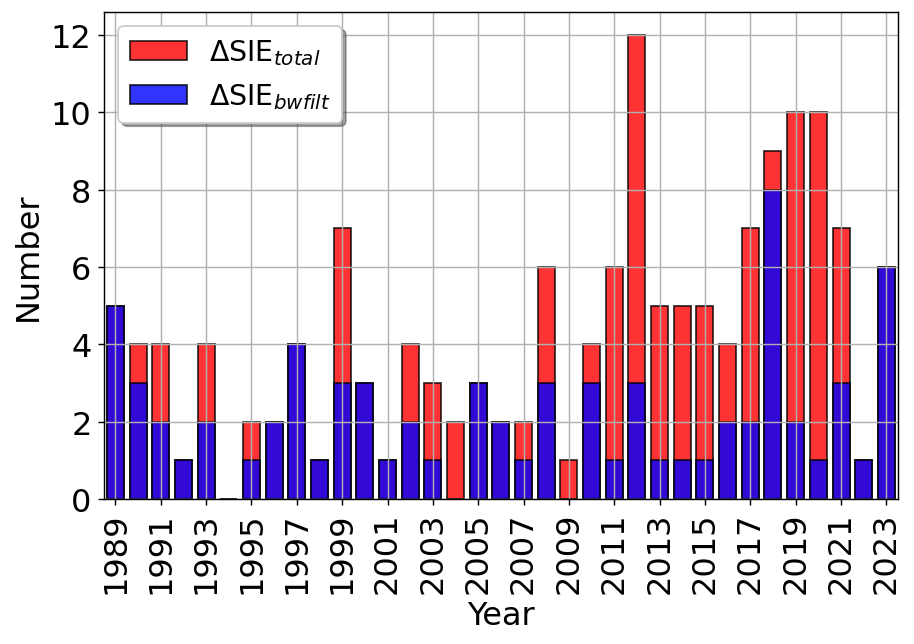

In [14]:
rotang = 90
xticklabels_all = yearbins[1::2]
#xticklabels_all = yearbins[0::2]

if plot_option == 1:
    
    ntot_vrilesum = np.empty(len(yearbins))
    ntot_bw = np.empty(len(yearbins))
    ntot_mr = np.empty(len(yearbins))
    count = 0
    #years_jja_vrilesum
    #years_jja_vrile
    #years_jja
   
    for tt in yearbins:
        [indsnow] = np.where(years_jja == tt)
        ntot_bw[count] = len(indsnow)
        del indsnow

        [indsnow] = np.where(years_jja_vrile == tt)
        ntot_mr[count] = len(indsnow)
        del indsnow
        
        [indsnow] = np.where(years_jja_vrilesum == tt)
        ntot_vrilesum[count] = len(indsnow)
        del indsnow
 
        count += 1
    
    print(ntot_vrilesum)
    print(ntot_bw)
    print(yearbins)
    #################################
    # Figure 1
    #################################
    bar_width = 0.75
    opacity = 0.8
    fig = plt.figure(**figprops)   # New figure
    ax1 = fig.add_subplot(1, 1, 1)
    p1 = ax1.bar(yearbins, ntot_vrilesum, bar_width,
                 alpha=opacity, align='center',edgecolor='k',linewidth=1.0,
                 color='r',label=labeltext_meanplusbw)
    p2 = ax1.bar(yearbins, ntot_bw, bar_width,
                 alpha=opacity, align='center',edgecolor='k',linewidth=1.0,
                 color='b',label=labeltext_bw)
    
    ax1.grid(True, linestyle='-')
    ax1.set_xticks(xticklabels_all)
    
    um.label_options(ax1,fontsize=label_fontsize,xaxis_opt=False,yaxis_opt=True,bold_opt=False)
    
    #ax1.set_xticklabels(yearbins,rotation=rotang,fontsize=14)
    legend = ax1.legend(loc='upper left', shadow=True, fontsize=legend_fontsize+4)
    ax1.set_xticklabels(xticklabels_all,rotation=rotang,fontsize=label_fontsize)
    plt.xlim([yearbins[1]-0.5,yearbins[-1]+0.5])
    plt.xlabel('Year',fontsize=label_fontsize)
    ax1.set_ylabel('Number',fontsize=label_fontsize)
    save_name = 'seaiceloss_' + figdescript + '_vRiles_bargraph.png'
    plt.savefig(imagedir + save_name, bbox_inches='tight')

In [15]:
#if plot_option == 1:
if 1 == 0:
    [indsper1] = np.where( (yearbins_subset>=periods2compare_cutoffs[0]) & (yearbins_subset<periods2compare_cutoffs[1]))
    [indsper2] = np.where( (yearbins_subset>=periods2compare_cutoffs[1]) & (yearbins_subset<periods2compare_cutoffs[2]))
    [indsper3] = np.where( (yearbins_subset>=periods2compare_cutoffs[2])) 
    ntot_per1 = np.sum(ntot[indsper1])
    ntot_per2 = np.sum(ntot[indsper2])
    ntot_per3 = np.sum(ntot[indsper3])
    ntot_per1_filt = np.sum(n_filt[indsper1])
    ntot_per2_filt = np.sum(n_filt[indsper2])
    ntot_per3_filt = np.sum(n_filt[indsper3]) 
    ntot_per1_unfilt = np.sum(n1_unfilt[indsper1])
    ntot_per2_unfilt = np.sum(n1_unfilt[indsper2])
    ntot_per3_unfilt = np.sum(n1_unfilt[indsper3])     
    #print(np.sum(ntot),ntot_per1,ntot_per2,ntot_per3)
    print('Totals: Total = %d, Period 1 = %d, Period 2 = %d, Period 3 = %d' %(np.sum(ntot), ntot_per1, ntot_per2, ntot_per3))
    print('Filtered: Total = %d, Period 1 = %d, Period 2 = %d, Period 3 = %d' %(np.sum(n_filt), ntot_per1_filt, ntot_per2_filt, ntot_per3_filt))
    print('Unfiltered: Total = %d, Period 1 = %d, Period 2 = %d, Period 3 = %d' %(np.sum(n1_unfilt), ntot_per1_unfilt, ntot_per2_unfilt, ntot_per3_unfilt))
    
    bar_width = 0.75
    opacity = 0.8

    #ntot_arr = np.array(ntot)
    ntot_adj = np.empty(len(yearbins))
    n_filt_adj = np.empty(len(yearbins))
    count = 0
    for tt in yearbins:
        [indcheck] = np.where(yearbins_subset == tt)
        if len(indcheck)>0:
            ntot_adj[count] = ntot[indcheck]
            n_filt_adj[count] = n_filt[indcheck]
        else:
            ntot_adj[count] = 0
            n_filt_adj[count] = 0
            
        count += 1
        
    print(ntot)
    print(ntot_adj)
    print(yearbins)
    print(yearbins_subset)
    
    #################################
    # Figure 2
    fig = plt.figure(**figprops)   # New figure
    ax1 = fig.add_subplot(1, 1, 1)
    p1 = ax1.bar(yearbins, ntot_adj, bar_width,
                 alpha=opacity, align='center',edgecolor='k',linewidth=1.0,
                 color='r',label=labeltext_meanplusbw)
    p2 = ax1.bar(yearbins, n_filt_adj, bar_width,
                 alpha=opacity, align='center',edgecolor='k',linewidth=1.0,
                 color='b',label=labeltext_bw)
    legend = ax1.legend(loc='upper left', shadow=True, fontsize=label_fontsize)
    ax1.grid(True, linestyle='-')
    ax1.set_xticks(yearbins)
    
    um.label_options(ax1,fontsize=label_fontsize,xaxis_opt=False,yaxis_opt=True,bold_opt=False)
    
    ax1.set_xticklabels(yearbins,rotation=rotang,fontsize=label_fontsize)
    plt.xlim([yearbins[0]-0.5,yearbins[-1]+0.5])
    plt.xlabel('Year',fontsize=label_fontsize)
    ax1.set_ylabel('Number',fontsize=label_fontsize)
    save_name = 'seaiceloss_' + figdescript + '_vRiles_bargraph.png'
    plt.savefig(imagedir + save_name, bbox_inches='tight')

   

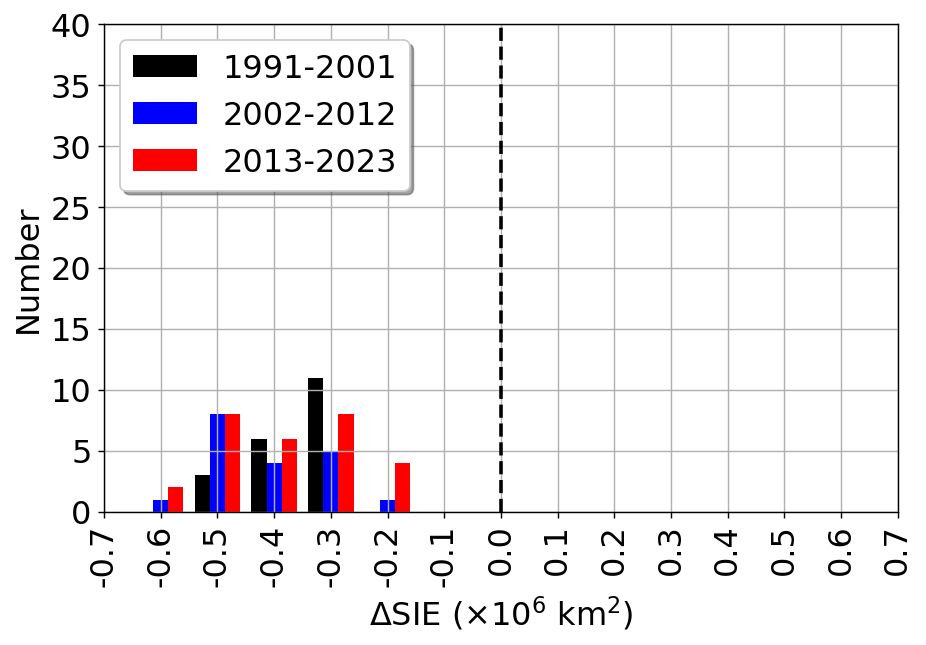

In [16]:
if 1 == 1:
    rotang = 90
    #anombins = np.arange(-0.6,0.6,0.1)
    anombins = np.array([-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
    
    binvals = anombins
    bincenters = (binvals[0:-1]+binvals[1:])/2.0
 
    dextent_period1 = np.array(dextent_period1)
    dextent_vrile_period1 = np.array(dextent_vrile_period1)
    dextent_nofilt_vrile_period1 = np.array(dextent_nofilt_vrile_period1)
    dextent_nofilt_vrilesum_period1 = np.array(dextent_nofilt_vrilesum_period1)
    dextent_vrile_period2 = np.array(dextent_vrile_period2)
    dextent_period2 = np.array(dextent_period2)
    dextent_nofilt_vrile_period2 = np.array(dextent_nofilt_vrile_period2)
    dextent_nofilt_vrilesum_period2 = np.array(dextent_nofilt_vrilesum_period2)
    dextent_vrile_period3 = np.array(dextent_vrile_period3)
    dextent_period3 = np.array(dextent_period3)
    dextent_nofilt_vrile_period3 = np.array(dextent_nofilt_vrile_period3)
    dextent_nofilt_vrilesum_period3 = np.array(dextent_nofilt_vrilesum_period3)
    
    [inds] = np.where(np.isfinite(dextent_nofilt_vrile_period3))
    dextent_nofilt_vrile_period3 = np.array(dextent_nofilt_vrile_period3[inds]).astype(float)
    [inds] = np.where(np.isfinite(dextent_vrile_period3))
    dextent_vrile_period3 = np.array(dextent_vrile_period3[inds]).astype(float)
    [inds] = np.where(np.isfinite(dextent_nofilt_vrilesum_period3))
    dextent_nofilt_vrilesum_period3 = np.array(dextent_nofilt_vrilesum_period3[inds]).astype(float)
    
    
    #bar_width = 0.75
    #opacity = 0.8
    #################################
    # Figure 2
    #################################
    fig = plt.figure(**figprops)   # New figure
    ax1 = fig.add_subplot(1, 1, 1)
    #p1 = ax1.bar(yearbins[:-1], ntot, bar_width,
    #             alpha=opacity, align='center',edgecolor='k',linewidth=1.0,
    #             color='r',label='All vRILEs')
    if plot_option == 1:
        #n1_unfilt, bins, patches = plt.hist(dextent_nofilt_vrile_period3, bins=binvals, normed=normval, facecolor='red', rwidth=0.75,alpha=alphaval,label='2008-2017')  
        colors = ['black', 'blue', 'red']
        #labels = ['1988-1997','1998-2007','2008-2017']
        #labels = ['1989-1998','1999-2008','2009-2018']
        #labels = [str(periods2compare_cutoffs[0]) + '-' + str(periods2compare_cutoffs[1]-1)]
        #print(labels)
        labels = [str(periods2compare_cutoffs[0]) + '-' + str(periods2compare_cutoffs[1]-1),str(periods2compare_cutoffs[1]) + '-' + str(periods2compare_cutoffs[2]-1),str(periods2compare_cutoffs[2]) + '-' + str(periods2compare_cutoffs[2]+10)]
        
        plt.hist([dextent_nofilt_period1,dextent_nofilt_period2,dextent_nofilt_period3], binvals, density=False, histtype='bar', align='right',color=colors, label=labels)
        #plt.hist([dextent_nofilt_vrile_period1,dextent_nofilt_vrile_period2,dextent_nofilt_vrile_period3], binvals, normed=0, histtype='bar', align='right',color=colors, label=labels)
        #plt.hist([dextent_vrile_period1,dextent_vrile_period2,dextent_vrile_period3], binvals, normed=0, histtype='bar', color=colors, label=labels)
        #plt.hist([dextent_nofilt_vrilesum_period1,dextent_nofilt_vrilesum_period2,dextent_nofilt_vrilesum_period3], binvals, normed=0, histtype='bar', align='right',color=colors, label=labels)
        
        #plt.legend(prop={'size': 10})
        #n_filt, bins, patches = plt.hist(dextent_vrile_period3, bins=binvals, normed=normval, facecolor='red', rwidth=1.00, alpha=alphaval, label='JJA (filtered)')
        #ntot = n1_unfilt+n_filt
    elif plot_option == 2:
        n1, bins, patches = ax1.hist(dextent_nofilt_vrile_period3, bins=binvals, density=False, facecolor='blue', alpha=alphaval, rwidth = 1.00)       
        #n2, bins, patches = ax1.hist(dextent_vrile_period3, bins=binvals, normed=normval, facecolor='red', alpha=alphaval, rwidth = 1.00)    
        #ntot = n1 + n2
        #bincenters = 0.5*(bins[1:]+bins[:-1])
        n1[1:] = um.smooth_onedim(n1[1:],npasses_smooth) 
        #n2[1:] = um.smooth_onedim(n2[1:],npasses_smooth) 
    
        #p1, = ax1.plot(bincenters,n1,'b-',linewidth=3.0,label='Annual')
        #p2, = ax1.plot(bincenters,n2,'r-',linewidth=3.0,label='JJA')
    
        #plt.ylim([0, 0.06])
    ax1.grid(True, linestyle='-')
    plt.axvline(0.0, color='k', linestyle='dashed', linewidth=2)
    ax1.yaxis.grid(True, linestyle='-')
    legend = ax1.legend(loc='upper left', shadow=True, fontsize=label_fontsize)
    #plt.title(titletext1,fontsize=label_fontsize)
    #ax1.set_xticks(bincenters)
    
    um.label_options(ax1,fontsize=label_fontsize,xaxis_opt=False,yaxis_opt=True,bold_opt=False)
    
    ax1.set_xticks(binvals)
    ax1.set_xticklabels(binvals,rotation=rotang,fontsize=label_fontsize)
    plt.xlim([binvals[0],binvals[-1]])
    #plt.ylim([0,25])
    plt.ylim([0,40])
    if plot_option == 1:
        plt.ylabel('Number',fontsize=label_fontsize)
        figname_suffix = 'histogram'
    elif plot_option == 2:
        plt.ylabel('Probability',fontsize=label_fontsize)
        figname_suffix = 'pdf'

    plt.xlabel(r'$\Delta$SIE ($\times 10^6$ km$^2$)',fontsize=label_fontsize)
    save_name = 'seaiceloss_' + figdescript + '_anombins_' + figname_suffix + '.png'
    plt.savefig(imagedir + save_name, bbox_inches='tight')

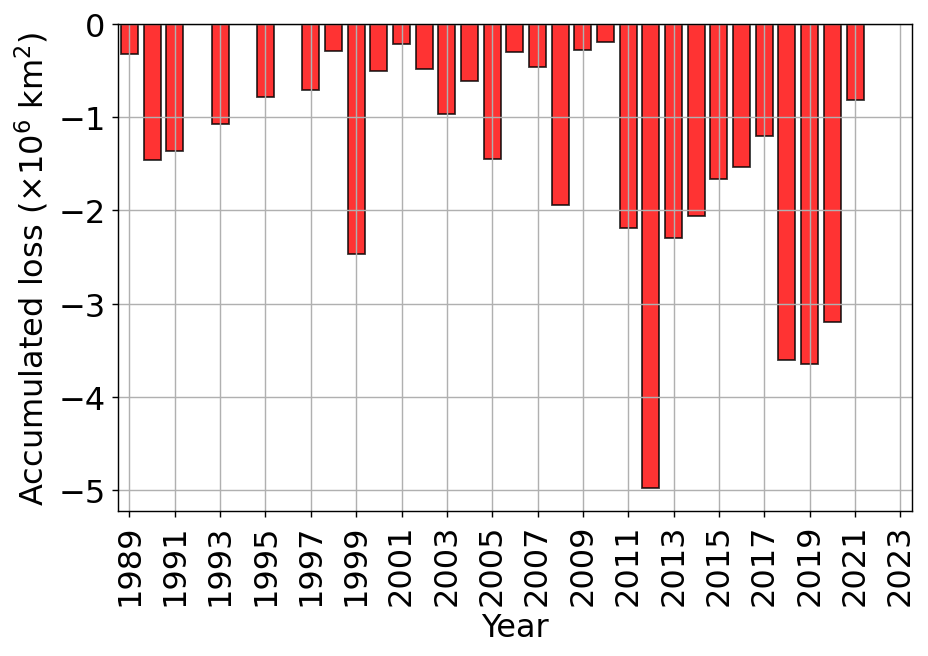

In [17]:
#values_plot = dextent_int_years_jja_nofilt
values_plot = dextent_nofilt_vrilesum_jja
n_groups = np.size(values_plot)
index = np.arange(n_groups)
bar_width = 0.75
opacity = 0.8
y_pos = np.arange(len(values_plot))
xcenters = (yearbins[0:-1]+yearbins[1:])/2.0

#################################
# Figure 3
fig = plt.figure(**figprops)   # New figure
ax1 = fig.add_subplot(1, 1, 1)
#p1, = ax1.plot(yearbins,dextent_int_years_jja_nofilt,'r',linewidth=3.0,label=r'$\Sigma[\Delta$Extent from events]')
p1 = ax1.bar(yearbins, values_plot, bar_width,
                 alpha=opacity, align='center',edgecolor='k',linewidth=1.0,
                 color='r',label='Cumulative ice loss from events')
#legend = ax1.legend(loc='Lower left', shadow=True, fontsize=label_fontsize)
ax1.grid(True, linestyle='-')

um.label_options(ax1,fontsize=label_fontsize,xaxis_opt=False,yaxis_opt=True,bold_opt=False)

ax1.set_xticks(xticklabels_all)
#ax1.set_xticklabels(yearbins,rotation=rotang,fontsize=14)
ax1.set_xticklabels(xticklabels_all,rotation=rotang,fontsize=label_fontsize)
plt.xlim([yearbins[1]-0.5,yearbins[-1]+0.5])
plt.xlabel('Year',fontsize=label_fontsize)
ax1.set_ylabel(r'Accumulated loss ($\times 10^6$ km$^2$)',fontsize=label_fontsize)
save_name = 'seaiceloss_' + figdescript + '_eventsum_bargraph.png'
plt.savefig(imagedir + save_name, bbox_inches='tight')

The percent differences are:
[        nan  2.15928024  8.94443423  8.55527638 -0.          6.62870582
 -0.          4.97550423 -0.          4.71218029  1.7828201  13.43259251
  3.12730854  1.44642974  2.81902552  6.03174603  3.89159138  8.54303857
  1.93079717  2.37317996  9.77780012  1.5605253   1.06061439 10.96932393
 21.55112652 12.60850456 11.58612144  8.70654557  8.54411029  6.44970732
 20.39786896 20.20028771 16.25171834  4.70703463 -0.         -0.        ]
Slope from percent ice loss is  2.1422 percent per decade with a p-value of 3.458070e-02
 
MatrixSize =  35
MatrixShape =  (35,)
NElements =  35
NAnalyzedElements =  35
Mean =  0.325326551705407
Median =  0.29803270344213306
Max =  0.9281030378598958
Min =  0.0
Range =  0.9281030378598958
StDev =  0.25734576978285983
MeanAbs =  0.325326551705407
MinAbs =  0.04868220036269655
FracZero =  0.14285714285714285
FracNaN =  0.0
[0.14877441 0.5375605  0.5355603  0.         0.40832828 0.
 0.2980327  0.         0.3110039  0.11213938 0.7

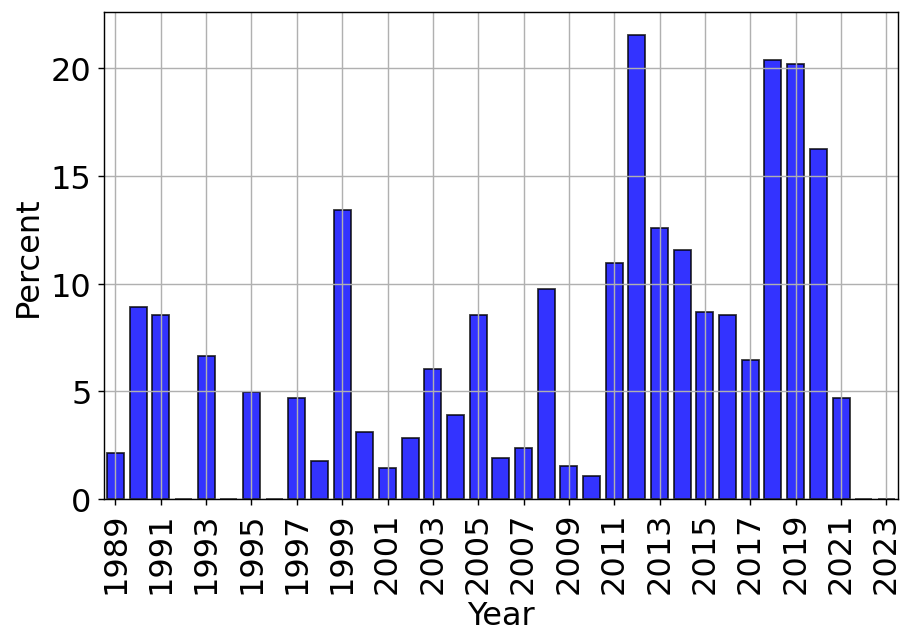

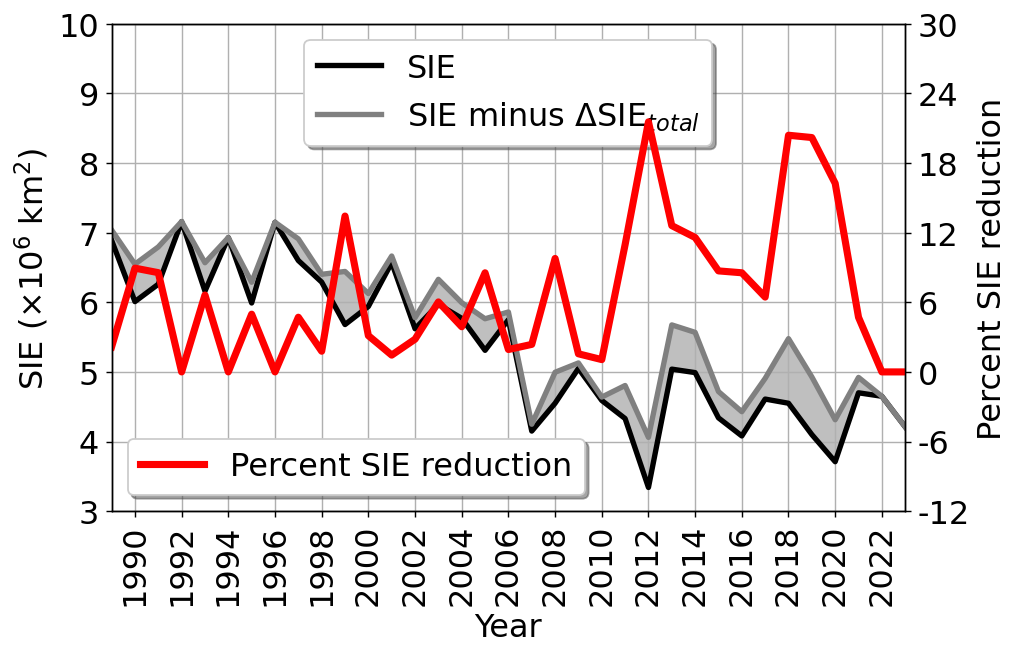

In [18]:
# Plot percent change from events
if plot_percent_from_events == 'True':
    #values_plot = percent_dextent_int_years_jja_nofilt
    values_plot = percent_dextent_jja_nofilt_vrilesum 
    facnow = 1.0+(percent_dextent_jja_nofilt_vrilesum/100.)
    #values_plot = percent_dextent_jja_nofilt_vriles
    #facnow = 1.0+(percent_dextent_jja_nofilt_vriles/100.)
    #values_plot = percent_dextent_jja_nofilt_cases
    #facnow = 1.0+(percent_dextent_jja_nofilt_cases/100.)    
    
    n_groups = np.size(values_plot)
    index = np.arange(n_groups)
    bar_width = 0.75
    opacity = 0.8
    y_pos = np.arange(len(values_plot))
    xcenters = (yearbins[0:-1]+yearbins[1:])/2.0

    [indassess] = np.where(~np.isnan(values_plot))
    slope, intercept, r_value, p_value, std_err = stats.linregress(yearbins[indassess],values_plot[indassess]*10.)
    print('The percent differences are:')
    print(values_plot)
    print('Slope from percent ice loss is %7.4f percent per decade with a p-value of %e' %(slope,p_value))
    
    
    #################################
    # Figure 4
    fig = plt.figure(**figprops)   # New figure
    ax1 = fig.add_subplot(1, 1, 1)
    #p1, = ax1.plot(yearbins,dextent_int_years_jja_nofilt,'r',linewidth=3.0,label=r'$\Sigma[\Delta$Extent from events]')
    p1 = ax1.bar(yearbins, values_plot, bar_width,
                 alpha=opacity, align='center',edgecolor='k',linewidth=1.0,
                 color='b',label='Percent ice loss from events')
    #legend = ax1.legend(loc='Lower left', shadow=True, fontsize=label_fontsize)
    
    ax1.grid(True, linestyle='-')
    ax1.set_xticks(xticklabels_all)
    #ax1.set_xticklabels(yearbins,rotation=rotang,fontsize=14)
    ax1.set_xticklabels(xticklabels_all,rotation=rotang,fontsize=label_fontsize)
    #for tick in ax1.yaxis.get_major_ticks():
    #    tick.label.set_fontsize(20) 
    um.label_options(ax1,fontsize=label_fontsize,xaxis_opt=False,yaxis_opt=True,bold_opt=False)
    plt.xlim([yearbins[1]-0.5,yearbins[-1]+0.5])
    plt.xlabel('Year',fontsize=label_fontsize)
    #ax1.set_ylabel(r'Percent of total JJA loss from events',fontsize=label_fontsize)
    ax1.set_ylabel('Percent',fontsize=label_fontsize)
    save_name = 'seaiceloss_' + figdescript + '_eventpercentchange_bargraph.png'
    plt.savefig(imagedir + save_name, bbox_inches='tight')
    
    ##############################################
    #facnow = 1.0+(percent_dextent_int_years_jja_nofilt/100.)
    #extent_minseptextent_noevents = extent_minseptextent*facnow[:-1]
    #print(percent_dextent_jja_nofilt)

    extent_minseptextent_noevents = extent_minseptextent*facnow[1:]
    
    minsept_anomaly = False
    if minsept_anomaly == True:
        [clim_inds] = np.where( (years_minseptextent>=1981) & (years_minseptextent<=2010))
        
        meansept = np.empty(len(extent_minseptextent))
        meansept[:] = np.nanmean(extent_minseptextent[clim_inds])
 
        polycoefs = np.polyfit(years_minseptextent,extent_minseptextent,2) # second order polynomial fit
        extent_fit = np.polyval(polycoefs,years_minseptextent)
                
        #extent_minseptextent = (extent_minseptextent - meansept)/np.std(extent_minseptextent)
        #extent_minseptextent_noevents = (extent_minseptextent_noevents - meansept)/np.std(extent_minseptextent)
        extent_minseptextent = (extent_minseptextent - extent_fit)/np.std(extent_fit)
        extent_minseptextent_noevents = (extent_minseptextent_noevents - extent_fit)/np.std(extent_fit)        
        
        alphalims = [-2,2.1]
        alphacint = 0.5
    else:
        alphalims = [3,11]
        alphacint = 1
    
    #betalims = [0,35]
    betalims = [-3,33]
     
    diffprint =  extent_minseptextent_noevents - extent_minseptextent
    mstats(diffprint)
    print(diffprint)
        
    [nas] = np.where(~np.isnan(extent_minseptextent) & ~np.isnan(extent_minseptextent_noevents) )
    
    cornow,pnow = stats.pearsonr(extent_minseptextent[nas],extent_minseptextent_noevents[nas])
    print('The correlation between Sept 1 extent and Sept 1 extent without events is %7.2f with p-value of %e' %(cornow,pnow))
    #################################
    # Figure 5
    #################################
    yticks_alpha = np.arange(alphalims[0],alphalims[1],alphacint)
    #yticks_beta = np.ceil(np.linspace(betalims[0],betalims[1],len(yticks_alpha)))
    yticks_beta = [-12,-6,0,6,12,18,24,30]
    yticklabels_alpha = yticks_alpha
    yticklabels_beta = yticks_beta
    labeltext = r'SIE minus $\Delta$SIE$_{total}$'

    
    fig = pylab.figure(**figprops)   # New figure
    ax1 = fig.add_subplot(1, 1, 1)
    p1, = ax1.plot(years_minseptextent,extent_minseptextent,'k',linewidth=3.0,label='SIE')
    p2, = ax1.plot(years_minseptextent,extent_minseptextent_noevents,'0.5',linewidth=3.0,label=labeltext)
    ax1.fill_between(years_minseptextent,extent_minseptextent, extent_minseptextent_noevents, facecolor='0.75')
    ax1.set_ylim(yticks_alpha[0],yticks_alpha[-1])
    ax1.yaxis.set_ticks(yticks_alpha)
    ax1.set_yticklabels(yticks_alpha,fontsize=label_fontsize)
    
    ax2 = ax1.twinx()
    p3, = ax2.plot(yearbins,values_plot,'r',linewidth=4.0,label='Percent SIE reduction')
    ax2.set_ylim(yticks_beta[0],yticks_beta[-1])
    ax2.yaxis.set_ticks(yticks_beta)
    ax2.set_yticklabels(yticks_beta,fontsize=label_fontsize)
    ax2.set_ylabel('Percent SIE reduction',fontsize=label_fontsize)
    
    ax1.grid(True, linestyle='-')
    if minsept_anomaly == True:
        ax1.set_ylabel('Standard deviations',fontsize=label_fontsize)
    else:
        ax1.set_ylabel(r'SIE ($\times 10^6$ km$^2$)',fontsize=label_fontsize)
    ax1.set_xlabel('Year',fontsize=label_fontsize)
    ax1.set_xticks(years_minseptextent[1::2])
    ax1.set_xticklabels(years_minseptextent[1::2],rotation=rotang,fontsize=label_fontsize)
    ax1.set_xlim(years_minseptextent[0],years_minseptextent[-1])

    legend = ax1.legend(loc='upper center', shadow=True,fontsize=label_fontsize)
    legend = ax2.legend(loc='lower left', shadow=True,fontsize=label_fontsize)
    save_name = imagedir + 'septmin_sea_ice_extent_timeseries_witheventchange' + '.png'
    plt.savefig(save_name, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


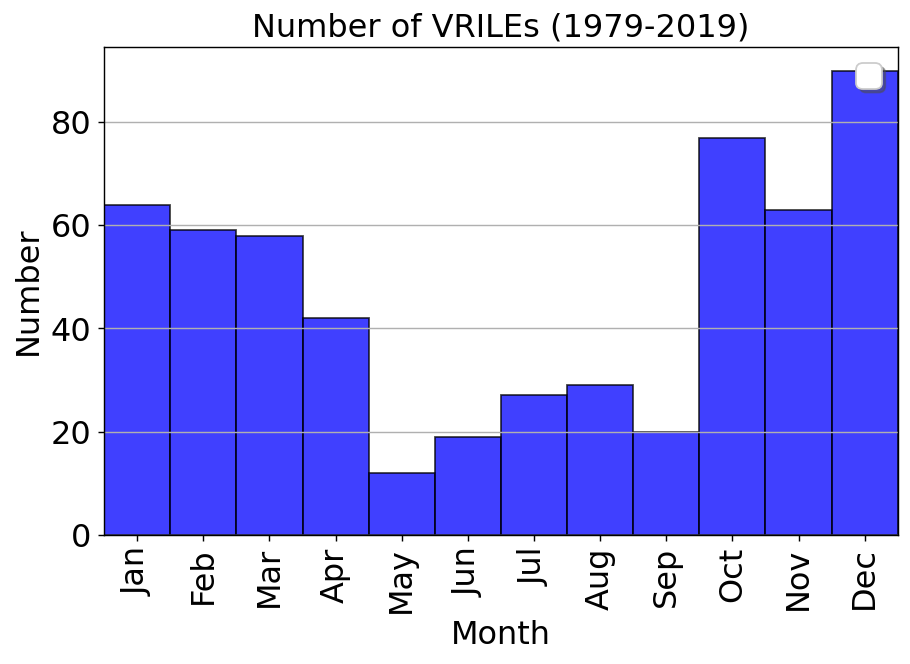

In [19]:
binvals = monthbins
#bincenters = (binvals[0:-1]+binvals[1:])/2.0
bincenters = np.zeros(len(binvals))
bincenters[0:-1] = 0.5*(binvals[1:]+binvals[:-1])
bincenters[-1] = bincenters[-2]+1.0

#################################
# Figure 6
#################################
fig = plt.figure(**figprops)   # New figure
ax1 = fig.add_subplot(1, 1, 1)


rotang = 90
if plot_option == 1:
    ax1.hist(months_plot,bins=binvals, density=False, facecolor='blue', edgecolor='black',alpha=alphaval, rwidth = 1.00)
    #ax1.hist(months_jja,bins=binvals, normed=normval, facecolor='red', alpha=alphaval, rwidth = 1.00)
elif plot_option == 2:
    del n1
    n1, bins1, patches = ax1.hist(months_plot, bins=binvals, density=False, facecolor='blue', alpha=alphaval, rwidth = 1.00)       
    #bincenters = 0.5*(bins[1:]+bins[:-1])
    
    #n1[1:] = um.smooth_onedim(n1[1:],npasses_smooth) 
    p1, = ax1.plot(bincenters[0:-1],n1,'b-',linewidth=3.0,label='Annual')   
    #plt.ylim([0, 0.06])
    
    
ax1.yaxis.grid(True, linestyle='-')
legend = ax1.legend(loc=leg_loc, shadow=True, fontsize=label_fontsize)
plt.title('Number of VRILEs (1979-2019)',fontsize=label_fontsize)
#plt.title(titletext1,fontsize=label_fontsize)
#plt.xlim([binvals[0],binvals[-1]])

um.label_options(ax1,fontsize=label_fontsize,xaxis_opt=False,yaxis_opt=True,bold_opt=False)
ax1.set_xticks(bincenters[0:-1])
ax1.set_xticklabels(month_list,rotation=rotang,fontsize=label_fontsize)
plt.xlim([binvals[0],binvals[-1]])

if plot_option == 1:
    plt.ylabel('Number',fontsize=label_fontsize)
    figname_suffix = 'histogram'
elif plot_option == 2:
    plt.ylabel('Probability',fontsize=label_fontsize)
    figname_suffix = 'pdf'

plt.xlabel('Month',fontsize=label_fontsize)
save_name = 'seaiceloss_' + figdescript + '_months_' + figname_suffix + '.png'
plt.savefig(imagedir + save_name, bbox_inches='tight')
#plt.show()

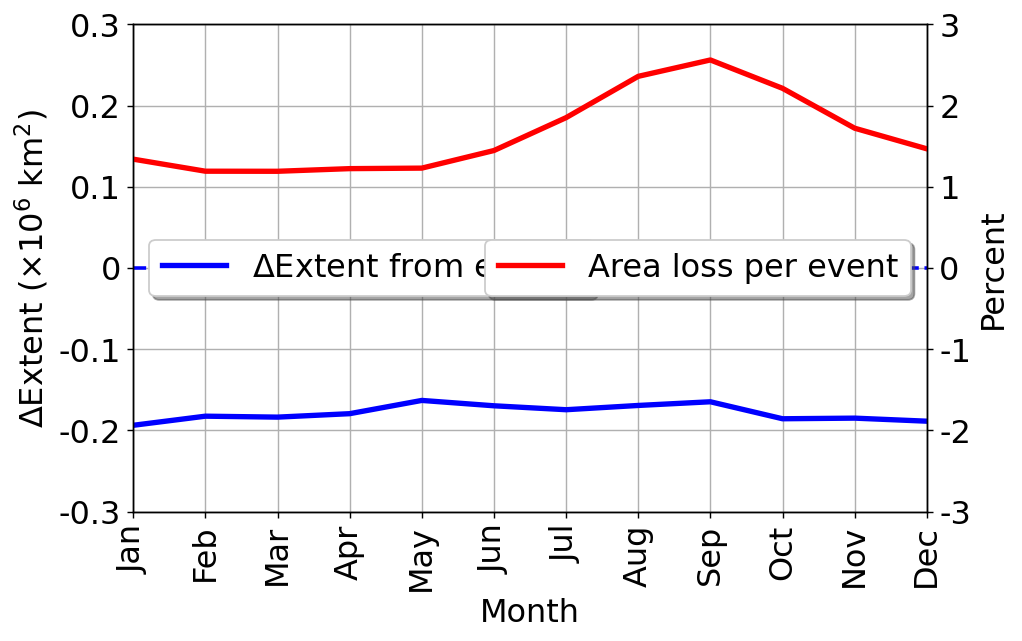

In [20]:
binvals = np.arange(1,13)
#bincenters = (binvals[0:-1]+binvals[1:])/2.0
bincenters = np.zeros(len(binvals))
bincenters[0:-1] = 0.5*(binvals[1:]+binvals[:-1])
bincenters[-1] = bincenters[-2]+1.0

yticks1 = [-0.3, -0.2,-0.1,   0, 0.1,0.2,0.3]
yticks2 = [-3,      -2,  -1,   0,   1,  2,  3]
#yticks2 = [-0.03,-0.02,-0.01,   0,0.01,0.02,0.03]
#yticks2 = [   0, 0.01,0.02,0.03,0.04]

#################################
# Figure 8
fig = plt.figure(**figprops)   # New figure
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()


rotang = 90
z0 = np.zeros_like(binvals).astype('f')
p1, = ax1.plot(binvals, dextent_int_months,'b',linewidth=3.0,label=r'$\Delta$Extent from events')
p3, = ax1.plot(binvals,z0,'b--',linewidth=2.0)
p4, = ax2.plot(binvals,perc_area,'r',linewidth=3.0,label='Area loss per event')    
    
ax1.grid(True, linestyle='-')
legend = ax1.legend(loc='center left', shadow=True, fontsize=label_fontsize)
legend = ax2.legend(loc='center right', shadow=True, fontsize=label_fontsize)
#plt.title(titletext1,fontsize=label_fontsize)
#plt.xlim([binvals[0],binvals[-1]])

ax1.set_xticks(binvals)
ax1.set_xticklabels(month_list,rotation=rotang,fontsize=label_fontsize)

ax1.set_yticks(yticks1)
ax1.set_yticklabels(yticks1,fontsize=label_fontsize)
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2,fontsize=label_fontsize)

plt.xlim([binvals[0],binvals[-1]])

ax1.set_ylabel(r'$\Delta$Extent ($\times 10^6$ km$^2$)',fontsize=label_fontsize)
ax2.set_ylabel('Percent',fontsize=label_fontsize)
figname_suffix = 'values'
ax1.set_xlabel('Month',fontsize=label_fontsize)
save_name = 'seaiceloss_' + figdescript + '_dextents_' + figname_suffix + '.png'
plt.savefig(imagedir + save_name, bbox_inches='tight')
#plt.show()

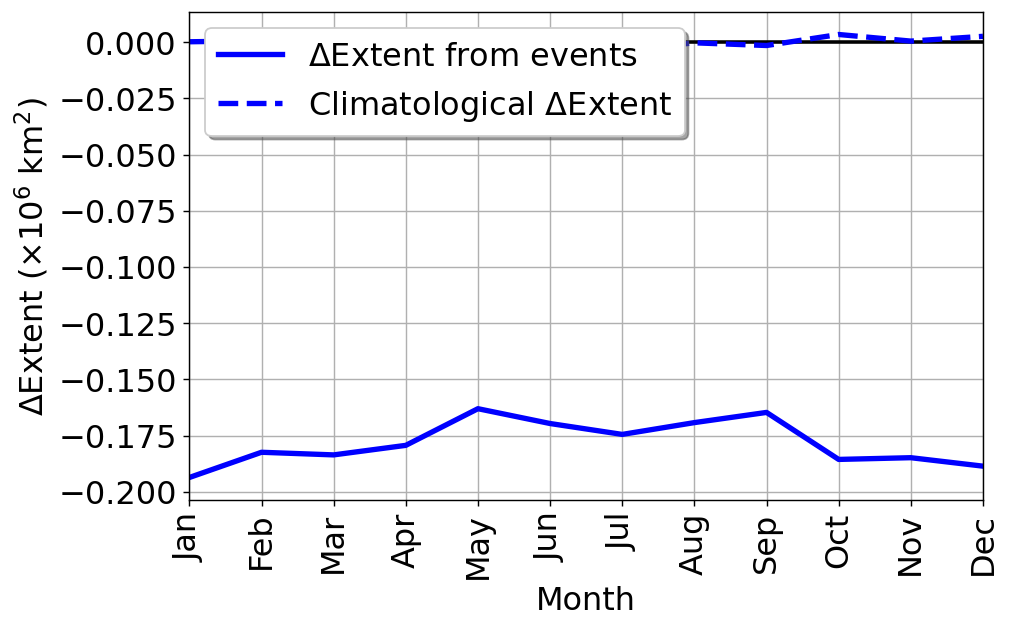

In [21]:
binvals = np.arange(1,13)
#bincenters = (binvals[0:-1]+binvals[1:])/2.0
bincenters = np.zeros(len(binvals))
bincenters[0:-1] = 0.5*(binvals[1:]+binvals[:-1])
bincenters[-1] = bincenters[-2]+1.0

yticks1 = [-0.3, -0.2,-0.1,   0, 0.1, 0.2, 0.3]
yticks2 = [-0.03,-0.02,-0.01,   0,0.01,0.02,0.03]
#yticks2 = [   0, 0.01,0.02,0.03,0.04]

#################################
# Figure 9
fig = plt.figure(**figprops)   # New figure
ax1 = fig.add_subplot(1, 1, 1)


rotang = 90
z0 = np.zeros_like(binvals).astype('f')
p1, = ax1.plot(binvals, dextent_int_months,'b',linewidth=3.0,label=r'$\Delta$Extent from events')
p3, = ax1.plot(binvals,z0,'k',linewidth=2.0)
p2, = ax1.plot(binvals,dextent_int_monthly_climo,'b--',linewidth=3.0,label=r'Climatological $\Delta$Extent')    
    
ax1.grid(True, linestyle='-')
legend = ax1.legend(loc='upper left', shadow=True, fontsize=label_fontsize)
#plt.title(titletext1,fontsize=label_fontsize)
#plt.xlim([binvals[0],binvals[-1]])

um.label_options(ax1,fontsize=label_fontsize,xaxis_opt=False,yaxis_opt=True,bold_opt=False)

ax1.set_xticks(binvals)
ax1.set_xticklabels(month_list,rotation=rotang,fontsize=label_fontsize)

#ax1.set_yticks(yticks1)
#ax1.set_yticklabels(yticks1)


plt.xlim([binvals[0],binvals[-1]])

ax1.set_ylabel(r'$\Delta$Extent ($\times 10^6$ km$^2$)',fontsize=label_fontsize)

figname_suffix = 'values'
ax1.set_xlabel('Month',fontsize=label_fontsize)
save_name = 'seaiceloss_' + figdescript + '_dextents_vsclimo_' + figname_suffix + '.png'
plt.savefig(imagedir + save_name, bbox_inches='tight')
plt.show()